# Modeling foam flow in porous media
I'm solving 1D and 2D foam flow in porous media numerically and analytically.

In [57]:
using PyPlot
using JFVM

## Physical properties and rel-perms

In [58]:
muw = 0.001 # water viscosity
mug = 2e-5 # gas viscosity
perm_ave = 1e-12 # permeability
poros_ave = 0.2 # porosity
fmmob = 25000
fmdry = 0.29
epdry = 10000
swc = 0.1
sgr = 0.05
krg0 = 0.94
ng = 1.3
krw0 = 0.2
nw = 4.2
# sws(sw)=((sw.>swc).*(sw.<(1-sgr)).*(sw-swc)/(1-sgr-swc))+(sw.>(1-sgr)).*ones(size(sw))
# kr(sw)=(krg0*(1-sws(sw)).^ng)
# fm(sw)=(1+fmmob*(0.5+atan(epdry.*(sw-fmdry))/π))
# krg(sw)=(kr(sw)./fm(sw))
# krw(sw)=(krw0*sws(sw).^nw)
# dkrwdsw(sw)=(nw*krw0*(1/(1-sgr-swc))*sws(sw).^(nw-1))
# dkrdsw(sw)=((krg0*ng*(1-sws(sw)).^(ng-1))/(-swc-sgr+1))
# dfmdsw(sw)=(((epdry*fmmob)./(π*(epdry^2*(sw-fmdry).^2+1))))
# dkrgdsw(sw)=((dkrdsw(sw).*fm(sw)-dfmdsw(sw).*kr(sw))./fm(sw).^2)
# fw(sw)=((krw(sw)/muw)./(krw(sw)/muw+krg(sw)/mug))
# dfw(sw)=((dkrwdsw(sw)/muw.*(krw(sw)/muw+krg(sw)/mug)-
#     (dkrwdsw(sw)/muw+dkrgdsw(sw)/mug).*krw(sw)/muw)./
#     (krg(sw)/mug+krw(sw)/muw).^2)

sws(sw)=((sw>swc)*(sw<(1-sgr))*(sw-swc)/(1-sgr-swc))+(sw>(1-sgr))
kr(sw)=(krg0*(1-sws(sw))^ng)
fm(sw)=(1+fmmob*(0.5+atan(epdry*(sw-fmdry))/π))
krg(sw)=(kr(sw)/fm(sw))
krw(sw)=(krw0*sws(sw)^nw)
dkrwdsw(sw)=(nw*krw0*(1/(1-sgr-swc))*sws(sw)^(nw-1))
dkrdsw(sw)=((krg0*ng*(1-sws(sw))^(ng-1))/(-swc-sgr+1))
dfmdsw(sw)=(((epdry*fmmob)/(π*(epdry^2*(sw-fmdry)^2+1))))
dkrgdsw(sw)=((dkrdsw(sw)*fm(sw)-dfmdsw(sw)*kr(sw))/fm(sw)^2)
fw(sw)=((krw(sw)/muw)/(krw(sw)/muw+krg(sw)/mug))
dfw(sw)=((dkrwdsw(sw)/muw*(krw(sw)/muw+krg(sw)/mug)-
    (dkrwdsw(sw)/muw+dkrgdsw(sw)/mug)*krw(sw)/muw)/
    (krg(sw)/mug+krw(sw)/muw)^2)

dfw (generic function with 1 method)

## Domain & grid

In [59]:
# Geometry
m = 80 # number of cells in x direction
n = 50 # number of cells in y direction
W = 10 # width
H = 1 # height
x=[linspace(0,0.2,100); linspace(0.21, 1.0, 10)]
meshvar = createMesh1D(x)

JFVM.MeshStructure(1, [109], JFVM.CellSize{Float64}([0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202  …  0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778], [0.0], [0.0]), JFVM.CellLocation{Float64}([0.0010101, 0.0030303, 0.00505051, 0.00707071, 0.00909091, 0.0111111, 0.0131313, 0.0151515, 0.0171717, 0.0191919  …  0.205, 0.253889, 0.341667, 0.429444, 0.517222, 0.605, 0.692778, 0.780556, 0.868333, 0.956111], [0.0], [0.0]), JFVM.FaceLocation{Float64}([0.0, 0.0020202, 0.0040404, 0.00606061, 0.00808081, 0.010101, 0.0121212, 0.0141414, 0.0161616, 0.0181818  …  0.21, 0.297778, 0.385556, 0.473333, 0.561111, 0.648889, 0.736667, 0.824444, 0.912222, 1.0], [0.0], [0.0]), [1], [1])

## Assign the properties to the cells

In [60]:
poros = createCellVariable(meshvar, poros_ave)
perm = createCellVariable(meshvar, perm_ave)
mu_gas = createCellVariable(meshvar, mug) # gas viscosity
mu_water = createCellVariable(meshvar, muw) # water viscosity
Lg_ave = harmonicMean(perm./mu_gas)
Lw_ave = harmonicMean(perm./mu_water)
s = createCellVariable(meshvar, 0) # gas source term

JFVM.CellValue(JFVM.MeshStructure(1, [109], JFVM.CellSize{Float64}([0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202  …  0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778], [0.0], [0.0]), JFVM.CellLocation{Float64}([0.0010101, 0.0030303, 0.00505051, 0.00707071, 0.00909091, 0.0111111, 0.0131313, 0.0151515, 0.0171717, 0.0191919  …  0.205, 0.253889, 0.341667, 0.429444, 0.517222, 0.605, 0.692778, 0.780556, 0.868333, 0.956111], [0.0], [0.0]), JFVM.FaceLocation{Float64}([0.0, 0.0020202, 0.0040404, 0.00606061, 0.00808081, 0.010101, 0.0121212, 0.0141414, 0.0161616, 0.0181818  …  0.21, 0.297778, 0.385556, 0.473333, 0.561111, 0.648889, 0.736667, 0.824444, 0.912222, 1.0], [0.0], [0.0]), [1], [1]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Boundary conditions

In [61]:
BCp = createBC(meshvar) # all Neumann BC for pressure
BCs = createBC(meshvar) # saturation BC
BCp.left.a[:] = krg(0)*Lg_ave.xvalue[1] 
BCp.left.b[:] = 0 
u = 1e-3 
BCp.left.c[:] = -u
BCp.right.a[:]=0 
BCp.right.b[:] = 1
BCp.right.c[:] = 1e5
BCs.left.a[:] = 0 
BCs.left.b[:] = 1
BCs.left.c[:] = 0.0

0.0

## Solver setting and initialization

In [62]:
# initial condition
sw0 = createCellVariable(meshvar, 1.0, BCs) # initial gas saturation
s = createCellVariable(meshvar, 0) # gas source term
p0 = createCellVariable(meshvar, 1e5, BCp) # [Pa] initial pressure
sw_old = copyCell(sw0)
p_old = copyCell(p0)
sw = copyCell(sw_old)
p = copyCell(p_old)
pgrad = gradientTerm(p)
# solver setting
dt0 = 0.01 # [s] time step
dt=dt0
t=0
eps_sw = 1e-5
eps_p = 1e-2
t_final = 6.145

6.145

In [63]:
sw

JFVM.CellValue(JFVM.MeshStructure(1, [109], JFVM.CellSize{Float64}([0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202  …  0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778], [0.0], [0.0]), JFVM.CellLocation{Float64}([0.0010101, 0.0030303, 0.00505051, 0.00707071, 0.00909091, 0.0111111, 0.0131313, 0.0151515, 0.0171717, 0.0191919  …  0.205, 0.253889, 0.341667, 0.429444, 0.517222, 0.605, 0.692778, 0.780556, 0.868333, 0.956111], [0.0], [0.0]), JFVM.FaceLocation{Float64}([0.0, 0.0020202, 0.0040404, 0.00606061, 0.00808081, 0.010101, 0.0121212, 0.0141414, 0.0161616, 0.0181818  …  0.21, 0.297778, 0.385556, 0.473333, 0.561111, 0.648889, 0.736667, 0.824444, 0.912222, 1.0], [0.0], [0.0]), [1], [1]), [-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

## M & RHS for the explicit terms

In [64]:
RHSs = constantSourceTerm(s) # explicit source term to be added to the rhs
(BCMp, BCRHSp) = boundaryConditionTerm(BCp)

(
  [1  ,   1]  =  6.21386e-6
  [1  ,   2]  =  -6.21386e-6
  [111, 110]  =  0.5
  [111, 111]  =  0.5, [0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100000.0])

In [65]:
sw

JFVM.CellValue(JFVM.MeshStructure(1, [109], JFVM.CellSize{Float64}([0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202, 0.0020202  …  0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778, 0.0877778], [0.0], [0.0]), JFVM.CellLocation{Float64}([0.0010101, 0.0030303, 0.00505051, 0.00707071, 0.00909091, 0.0111111, 0.0131313, 0.0151515, 0.0171717, 0.0191919  …  0.205, 0.253889, 0.341667, 0.429444, 0.517222, 0.605, 0.692778, 0.780556, 0.868333, 0.956111], [0.0], [0.0]), JFVM.FaceLocation{Float64}([0.0, 0.0020202, 0.0040404, 0.00606061, 0.00808081, 0.010101, 0.0121212, 0.0141414, 0.0161616, 0.0181818  …  0.21, 0.297778, 0.385556, 0.473333, 0.561111, 0.648889, 0.736667, 0.824444, 0.912222, 1.0], [0.0], [0.0]), [1], [1]), [-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

## Main loop

In [66]:
while t<t_final
    error1 = 1e5
    error2 = 1e5
    loop_count =0
    while true
        loop_count=loop_count+1
        if loop_count>10
            p=copyCell(p_old)
            sw=copyCell(sw_old)
            dt=dt/2
            break
        end
        if (error1<=eps_sw)&&(error2<=eps_p)
            t=t+dt
            dt=dt0
            sw_old = copyCell(sw)
            p_old = copyCell(p)
            #print(t)
            #plot(log(L_ave.xvalue')) #shading interp drawnow
            #figure(1)  pcolor(1-sw.value(2:m+1,2:n+1)') shading interp colorbar drawnow
            #figure(1) visualizeCells(meshvar, sw.value) drawnow
#             figure(1)
#             subplot(2,1,1)plot(sw_ave.xvalue, 'o')
#             ylabel('S_w')
#             subplot(2,1,2) semilogy(L_ave.xvalue)
#             xlabel('x')
#             ylabel('total mobility')
#             drawnow
#             plot(t, p.value(2), 'o') drawnow
#             plot(L_ave.xvalue) drawnow
            break
        end
        # step 1) calculate the average values
#         sg_ave = arithmeticMean(meshvar, sg.value)
        sw_ave = upwindMean(sw, -pgrad)
        Lg = Lg_ave*faceEval(krg,sw_ave)
        Lw = Lw_ave*faceEval(krw,sw_ave)

        # step 2) calculate the pressure profile
        L_ave = Lw+Lg
        Meq = diffusionTerm(L_ave)
        

        # solve the linear system of equations and reshape the result
        Mp = Meq + BCMp
        RHSp = BCRHSp - RHSs # the whole continuity is multiplied by a minus sign
        p_new = solvePDE(meshvar, Mp, RHSp)
#         P = Mp\RHSp
#         p.value = reshape(full(P), m+2, n+2)

        pgrad = gradientTerm(p_new)
        error1=1e5
#         while error1>eps_sw
        for i = 1:3
            sw_ave = upwindMean(sw, -pgrad)
    #         Lg = Lg_ave.*krg(sw_ave)
            Lw = Lw_ave.*faceEval(krw,sw_ave)
    #         sw_ave = upwindMean(meshvar, -pgrad, sw.value)
        #     sw_ave = arithmeticMean(meshvar, sw.value)
    #         Lw = Lw_ave.*krw(sw_ave)
        #     Lo = Lo_ave.*kro(sw_ave)
            # step 3) calculate the new value of sw
            (Mtrans, RHStrans) = transientTerm(sw_old, dt, poros)
            u = -faceEval(dkrwdsw,sw_ave).*Lw_ave.*pgrad
            Mconv = convectionUpwindTerm(u)
    #       Mconv = convectionTerm(meshvar, u)
            facevar = (-Lw+faceEval(dkrwdsw,sw_ave).*Lw_ave.*sw_ave).*pgrad
            RHSdiv = divergenceTerm(facevar)
            (BCM, BCRHS) = boundaryConditionTerm(BCs)

            # construct the linear system
            M = Mtrans+Mconv+BCM
            RHS = RHStrans+BCRHS-RHSdiv+RHSs
            sw_new = solveLinearPDE(meshvar, M, RHS)
    #         SG = M\RHS
    #         sg_new = reshape(full(SG), m+2, n+2)
            error1 = sum(abs(sw_new.value[:]-sw.value[:]))
#             sw.value = 0.3*sw_new+0.7*sw.value
            sw=copyCell(sw_new)
        end
        error2 = maximum(abs.(p_new.value-p.value)./p_new.value)
#         p.value = 0.1*p.value+0.9*p_new
        p = copyCell(p_new)
    end

end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs(::Array{Float64,1}) at ./deprecated.jl:57
 [3] macro expansion at ./In[66]:77 [inlined]
 [4] anonymous at ./<missing>:?
 [5] include_string(::String, ::String) at ./loading.jl:522
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/ali/.julia/v0.6/IJulia/src/execute_request.jl:158
 [7] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/ali/.julia/v0.6/Compat/src/Compat.jl:378
 [8] eventloop(::ZMQ.Socket) at /home/ali/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[66], in expression starting on line 1


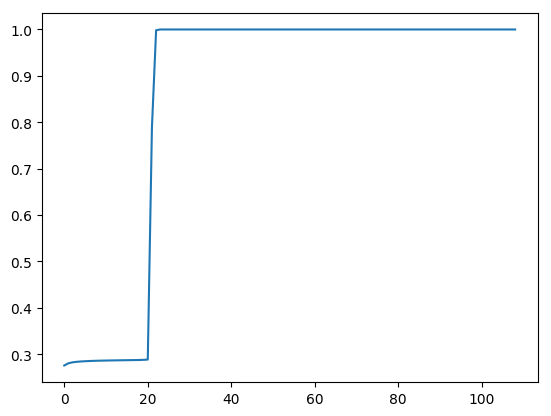

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe62c767fd0>

In [71]:
plot(sw.value[2:end-1])

In [72]:
find(((1-faceEval(sws, sw_ave)).xvalue).<0)

0-element Array{Int64,1}